In [76]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
import sys
from scipy.optimize import minimize
from tqdm import tqdm
from common import tool_times
from common import well_construction as wc
from common.sensor_types import sensors
from solvers.solver_cim_py.interface import Solver
import torch
import plotly
import plotly.graph_objs as go
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from typing import Tuple
import torch
import torch.optim as optim
from model import Net
model = torch.load('model_weights/modelentire.pth')
model.load_state_dict(torch.load('model_weights/model.pth'))
loss_function = nn.MSELoss()
model.eval()

def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu') # don't have GPU 
    return device

device = get_device()
net = model.double().to(device)

def weighted_mse(u_exp: np.ndarray, u: np.ndarray, time: np.ndarray, eps: float = + 10 ** (-15)) -> Tuple[np.ndarray, np.ndarray]:
    dt = np.diff(time, n=1, axis=0)
    dt = np.append(dt, dt[-1])
    amplitude = np.dot(dt, u * u_exp) / np.dot(dt, u ** 2)
    e = (u_exp - amplitude * u) / (u_exp + eps) * dt
    
    loss = np.dot(e, e)
    return loss



t = 1e-3 * np.array([
    0.135, 0.180, 0.235, 0.315, 0.365, 0.420,
    0.485, 0.560, 0.650, 0.750, 0.865, 1.000,
    1.155, 1.335, 1.540, 1.780, 2.055, 2.370,
    2.740, 3.160, 3.650, 4.215, 4.870, 5.625,
    6.495, 7.500, 8.660, 10.00, 11.55, 13.34,
    15.40, 17.79, 20.54, 23.72, 27.39, 31.63,
    36.52, 42.17, 48.70, 56.24, 64.94, 74.99,
    86.60, 100.0, 115.5, 133.4
])

df = pd.read_pickle('Dataset')
# #fix_normed_vector = df.sample(1) временно
# fix_normed_vector = df.loc[9030]
# fix_normed_vector = pd.DataFrame(fix_normed_vector).transpose()
# print ('Зафиксировали произвольный вектор из датафрейма с компонентами \n')
# fix_normed_vector

## Считаем лосс (сигма, мю) через модельную функцию

### Нахождение границ для оптимизатора с учетом параметров усреднения первоначальной выборки

In [109]:
means = np.fromfile('means_scaler')
#print(means)
stds = np.fromfile('stds_scaler')

real_min_sigma = df.describe()['Sigma']['min'] * stds[0] + means[0]
print ('real min sigma ', real_min_sigma)

norm_min_sigma =  df.describe()['Sigma']['min'] 
#print ('norm min sigma ',norm_min_sigma )

real_max_sigma = df.describe()['Sigma']['max'] * stds[0] + means[0]
print ('real max sigma ', real_max_sigma)

norm_max_sigma = df.describe()['Sigma']['max']
#print ('norm max sigma ', norm_max_sigma )

real_min_mu = df.describe()['mu']['min'] * stds[1] + means[1]
print('real min mu ', real_min_mu)

norm_min_mu = df.describe()['mu']['min']
#print ('norm min mu', norm_min_mu)

real_max_mu = df.describe()['mu']['max'] * stds[1] + means[1]
print ('real max mu ', real_max_mu)

norm_max_mu = df.describe()['mu']['max']
#print ('norm max mu ', norm_max_mu)

# #fix_real_vector = df.sample(1)
# fix_real_vector = fix_normed_vector[['Sigma', 'mu', 'd', 'th', 'th0']]
# fix_real_vector = fix_real_vector*stds+means
# fix_real_vector['Decay'] = fix_normed_vector['Decay']
# print ('Зафиксировали произвольный вектор из датафрейма с real компонентами \n')
# fix_real_vector

real min sigma  1000013.7854274483
real max sigma  9999922.0430012
real min mu  10.001820859598737
real max mu  149.9983173491276


In [110]:
import scipy.io
mat = scipy.io.loadmat('Solver2D_Pulse_3E_SS_3x12_v1.mat')
fix_real_vector = {'Sigma': [5302177], 'mu':[166], 'd':[89], 'th': [5.94], 'th0': [5.94]}
fix_real_vector = pd.DataFrame(data=fix_real_vector)
fix_normed_vector = (fix_real_vector - means) / stds
tmp = []
tmp.append(mat['med_decay'][0])
fix_real_vector['Decay'] = tmp
fix_real_vector

,Sigma,mu,d,th,th0,Decay
0,5302177,166,89,5.94,5.94,"[1.80675, 1.6877, 1.5754, 1.4504, 1.3862, 1.32..."


In [111]:
fix_normed_vector['Decay'] = tmp
fix_normed_vector

,Sigma,mu,d,th,th0,Decay
0,-0.075661,2.126981,0.0,-0.076213,-0.56,"[1.80675, 1.6877, 1.5754, 1.4504, 1.3862, 1.32..."


### Подсчет и построение тепловых карт лосса с помощью нейросети и модельной функции

In [137]:
def model_decay(d=fix_real_vector.get('d').iloc[0], th0=fix_real_vector.get('th0').iloc[0],
                th=fix_real_vector.get('th').iloc[0], sigma=fix_real_vector.get('Sigma').iloc[0],
                mu=fix_real_vector.get('mu').iloc[0]):
    tubes = [
        wc.Tube(d=(d), th0=(th0), th=(th), sigma=(sigma), mu=(mu)),
    ]

    sensor = sensors.PULSE_3E_1
    times = tool_times.times[sensor]
    solver = Solver(sensor, times, tool_averaging=True, verbose=0)
    output = solver.get_curve(tubes)
    return(output)

def model_loss(real_sigma,real_mu):
    return np.log(weighted_mse(np.array(fix_real_vector.get('Decay').iloc[0]), np.array(model_decay(sigma=real_sigma,
                                                                             mu=real_mu)),t))
def net_loss(norm_sigma, norm_mu):
    tensor = torch.tensor([fix_normed_vector.get('Sigma').iloc[0],norm_sigma,
                           fix_normed_vector.get('mu').iloc[0],norm_mu,
                           fix_normed_vector.get('th').iloc[0],fix_normed_vector.get('th').iloc[0]])
    tensor = tensor.to(device)
    output = net(tensor.double())
    return (output.item())

def l2_norm(norm_sigma, norm_mu):
     return np.linalg.norm([fix_normed_vector.get('Sigma').iloc[0] - norm_sigma,
                          fix_normed_vector.get('mu').iloc[0] - norm_mu])

def model_minimization_function(variable_vector, constant=0.5):
    real_sigma = variable_vector[0]
    real_mu = variable_vector[1]
    norm_sigma = (real_sigma - means[0]) / stds[0]
    norm_mu = (real_mu - means[1]) / stds[1]
    return (-1 * l2_norm(norm_sigma, norm_mu) + constant * model_loss(real_sigma, real_mu))

def net_minimization_function(variable_vector, constant=0.5):
    real_sigma = variable_vector[0]
    real_mu = variable_vector[1]
    norm_sigma = (real_sigma - means[0]) / stds[0]
    norm_mu = (real_mu - means[1]) / stds[1]
    return (-1 * l2_norm(norm_sigma, norm_mu) + constant * net_loss(real_sigma, real_mu))

#### Вычисление и построение карты model_loss and net_loss 

In [113]:
size = 30
sigma_real = np.linspace(real_min_sigma, real_max_sigma, num=size, retstep=True)#sigma
mu_real = np.linspace(real_min_mu, real_max_mu, num=size, retstep=True)#mu
i = 0
j = 0
loss_model = np.zeros((size,size))

In [114]:
import time
startTime = time.time() # время начала замер
for i in tqdm(range(size)):
    while (j < size):
        loss_model[i,j] = model_loss(sigma_real[0][j],mu_real[0][i])
        j = j + 1
    j = 0
endTime = time.time() #время конца замера
totalTime = endTime - startTime #вычисляем затраченное время
print("Время, затраченное на выполнение данного кода = ", totalTime)
loss_model = pd.DataFrame(loss_model)
loss_model.index = np.around(mu_real[0],1) 
loss_model.columns = np.around(sigma_real[0],3)
loss_model.to_pickle('./loss_model_model_matrix.pkl')
#loss_model = pd.read_pickle('./loss_model_model_matrix.pkl')

100%|███████████████████████████████████████| 30/30 [24:45<00:00, 49.50s/it]

Время, затраченное на выполнение данного кода =  1485.1244053840637


In [83]:
#loss_model = pd.read_pickle('./loss_model_model_matrix.pkl')

In [115]:
i = 0
j = 0
loss_net = np.zeros((size, size))
sigma_norm = (sigma_real[0] - means[0]) / stds[0] 
mu_norm = (mu_real[0] - means[1]) / stds[1]

startTime = time.time() # время начала замер
for i in tqdm(range(size)):
    while (j < size):
        loss_net[i][j] = net_loss(sigma_norm[j], mu_norm[i])
        j += 1
    j = 0
endTime = time.time() #время конца замера
totalTime = endTime - startTime #вычисляем затраченное время

print("Время, затраченное на выполнение данного кода = ", totalTime)
loss_net = pd.DataFrame(loss_net)
loss_net.index = np.around(mu_real[0],1) 
loss_net.columns = np.around(sigma_real[0],3)
loss_net.to_pickle('./loss_net_model_matrix.pkl')
#loss_net = pd.read_pickle('./loss_net_model_matrix.pkl')

100%|███████████████████████████████████████| 30/30 [00:00<00:00, 76.63it/s]

Время, затраченное на выполнение данного кода =  0.41454195976257324


In [85]:
#loss_net = pd.read_pickle('./loss_net_model_matrix.pkl')

#### Разница результатов классического и нейросетевого подхода логарифмическая

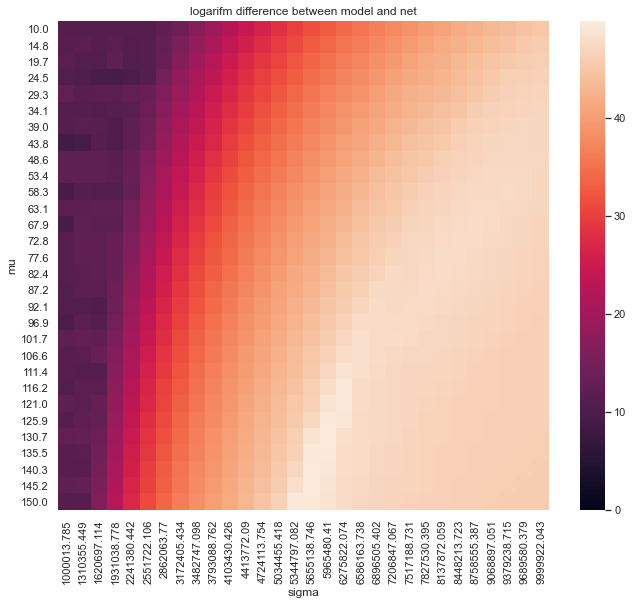

In [116]:
diff = abs(loss_model - loss_net)
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(diff, annot=False, vmin=0)
#name = 'log( loss( (' + str(fix_vector.get('mu').iloc[0])+ ', (' + str(fix_vector.get('Sigma').iloc[0]) + ')))'
name = "logarifm difference between model and net"
ax.set(xlabel='sigma', ylabel='mu', title=name)
# ax = f.gca()
# circle1 = plt.Circle((size/2,size/2), 0.5, color='g', fill=False, label="The zone of the fix vector")
# ax.add_patch(circle1)
# ax.legend()
f.savefig(name + '.png', bbox_inches='tight')

#### Разница результатов классического и нейросетевого подхода реальных данных

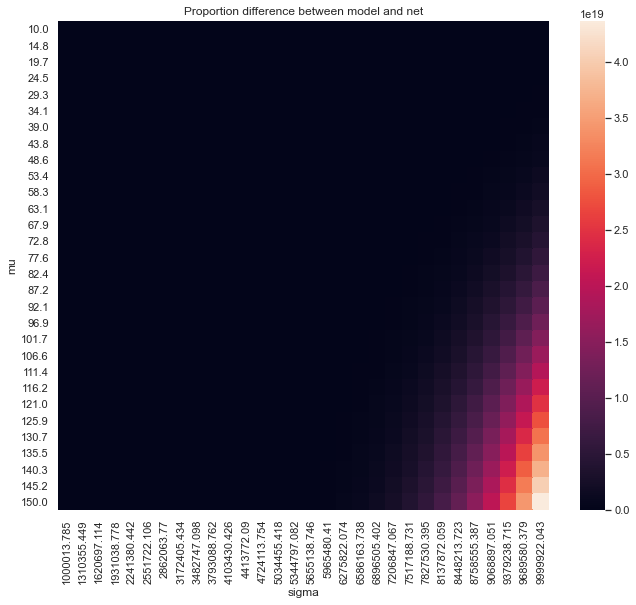

In [117]:
diff = abs(np.exp(loss_model) - np.exp(loss_net))
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(diff, annot=False)
#name = 'log( loss( (' + str(fix_vector.get('mu').iloc[0])+ ', (' + str(fix_vector.get('Sigma').iloc[0]) + ')))'
name = "Proportion difference between model and net"
ax.set(xlabel='sigma', ylabel='mu', title=name)
# ax = f.gca()
# circle1 = plt.Circle((size/2,size/2), 0.5, color='g', fill=False, label="The zone of the fix vector")
# ax.add_patch(circle1)
# ax.legend()
f.savefig(name + '.png', bbox_inches='tight')

#### Тепловая карта спадов модельных данных и нейросети

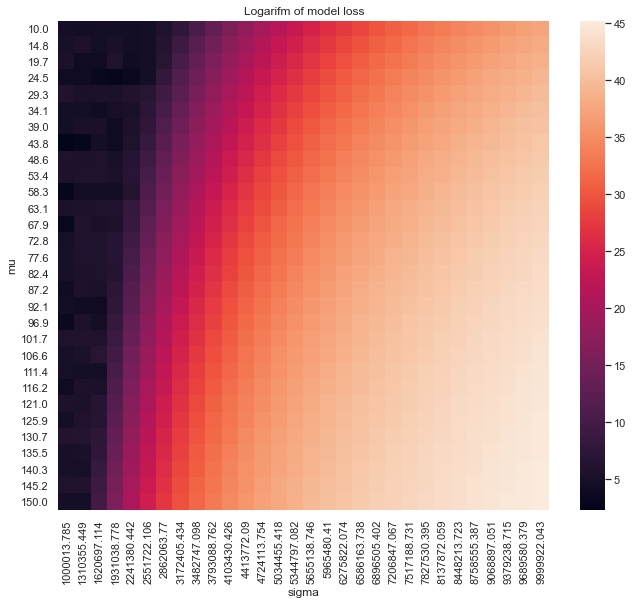

In [118]:
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(loss_model, annot=False)
name = "Logarifm of model loss"
ax.set(xlabel='sigma', ylabel='mu', title=name)
f.savefig(name + '.png', bbox_inches='tight')

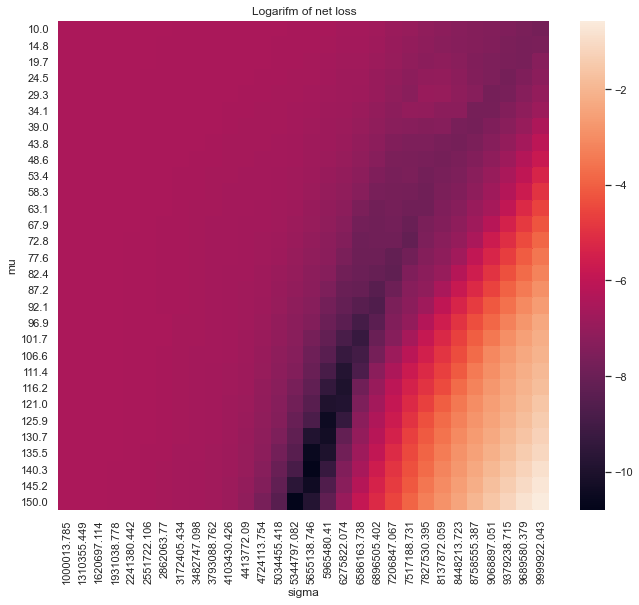

In [119]:
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(loss_net, annot=False)
name = "Logarifm of net loss"
ax.set(xlabel='sigma', ylabel='mu', title=name)
f.savefig(name + '.png', bbox_inches='tight')

### Подсчет и построение тепловой карты л2 нормы

In [120]:
sigma_norm = (sigma_real[0] - means[0]) / stds[0] 
mu_norm = (mu_real[0] - means[1]) / stds[1]
l2 = np.zeros((size, size))
i = 0
j = 0
for i in tqdm(range(size)):
    while (j < size):
        l2[i][j] = l2_norm(sigma_norm[j], mu_norm[i])
        j += 1
    j = 0
l2 = pd.DataFrame(l2)
l2.index = np.around(mu_real[0],1) 
l2.columns = np.around(sigma_real[0],3)
l2.to_pickle('./l2_matrix.pkl')
#l2 = pd.read_pickle('./l2_matrix.pkl')

100%|██████████████████████████████████████| 30/30 [00:00<00:00, 824.54it/s]


In [92]:
l2 = pd.read_pickle('./l2_matrix.pkl')

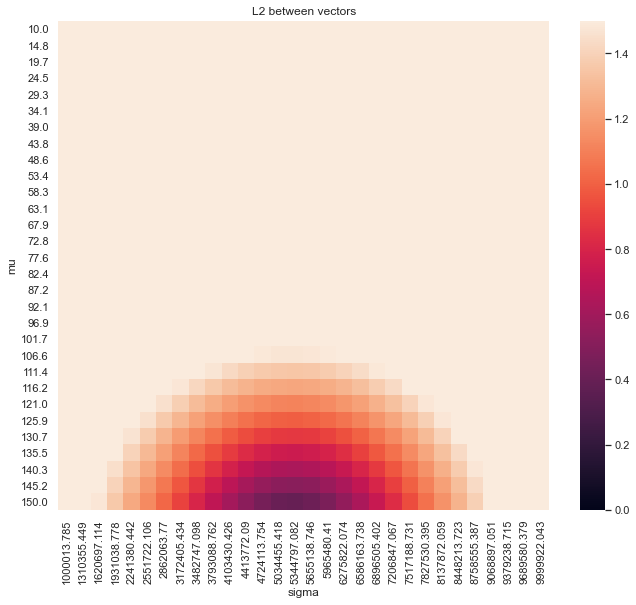

In [121]:
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(l2, annot=False, vmin=0, vmax=1.5)
name = "L2 between vectors"
ax.set(xlabel='sigma', ylabel='mu', title=name)
f.savefig(name + '.png', bbox_inches='tight')

### Взвешенная сумма -l2_norm + constant * loss_model

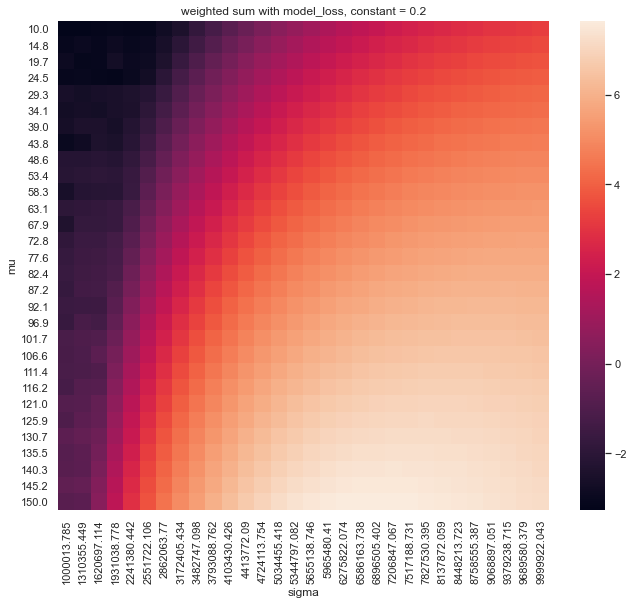

In [122]:
constant = 0.2
weighted_sum = -l2 + constant * loss_model
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(weighted_sum, annot=False)
name = "weighted sum with model_loss, constant = " + str(constant)
ax.set(xlabel='sigma', ylabel='mu', title=name)
f.savefig(name + '.png', bbox_inches='tight')

### Взвешенная сумма -l2_norm + constant * loss_model

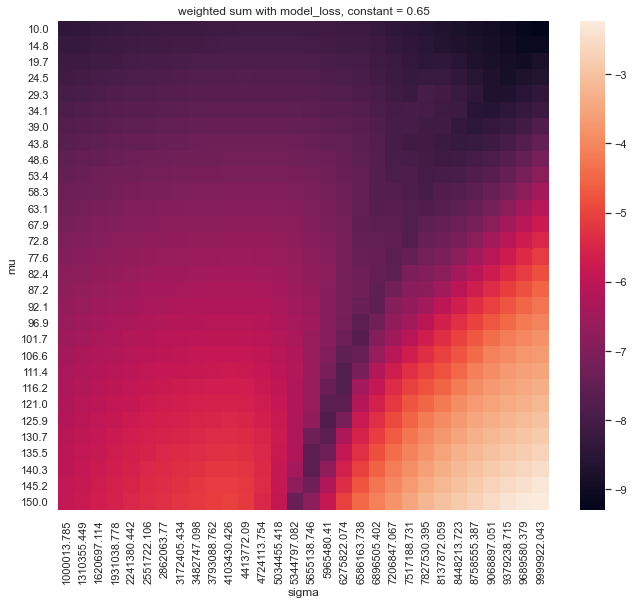

In [136]:
constant = 0.65
weighted_sum = -l2 + constant * loss_net
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(weighted_sum, annot=False)
name = "weighted sum with model_loss, constant = " + str(constant)
ax.set(xlabel='sigma', ylabel='mu', title=name)
f.savefig(name + '.png', bbox_inches='tight')

### Оптимизация model_minimization_function

In [302]:
# minimize_result_data = []
# constant = np.linspace(0.01,1,20)
# for const in tqdm(constant):
#     def model_minimization_function(variable_vector, constant=const):
#         real_sigma = variable_vector[0]
#         real_mu = variable_vector[1]
#         norm_sigma = (real_sigma - means[0]) / stds[0]
#         norm_mu = (real_mu - means[1]) / stds[1]
#         return (-1 * l2_norm(norm_sigma, norm_mu) + constant * model_loss(real_sigma, real_mu))   
#     x0 = np.array([fix_real_vector.get('Sigma').iloc[0],fix_real_vector.get('mu').iloc[0]])
#     res =  minimize(model_minimization_function, x0, method='SLSQP', bounds=((sigma_min[0][0] * stds[0] + means[0], 
#                                                                     sigma_max[0][0] * stds[0] + means[0]),
#                                                                    (mu_min[0][0] * stds[1] + means[1],
#                                                                     mu_max[0][0] * stds[1] + means[1])),options={'disp': False,
#                                                                                                                 'maxiter':1e6,
#                                                                                                                 'ftol':1e-9,
#                                                                                                                 'eps': 0.1})
#     minimize_result_data.append({'l2_norm': l2_norm((res.x[0] - means[0]) / stds[0], (res.x[1] - means[1]) / stds[1]),
#                                  'log_loss': model_loss(res.x[0], res.x[1]),
#                                  'loss': np.exp(model_loss(res.x[0], res.x[1])),
#                                  'constant': const, 'data': res.x, 'message': res.message})
# minimize_result_data = pd.DataFrame(minimize_result_data)
# minimize_result_data
# #print(res)

#### Оптимизация функции нормированных величин

## SLSQP

In [303]:
# minimize_result_data = []
# constant = np.linspace(0.001,0.2,20)
# for const in tqdm(constant):
#     def model_minimization_function(norm_variable_vector, constant=const):
#         real_sigma = norm_variable_vector[0] * stds[0] + means[0]
#         real_mu = norm_variable_vector[1] * stds[1] + means[1]
#         norm_sigma = norm_variable_vector[0]
#         norm_mu = norm_variable_vector[1]
#         return (-1 * l2_norm(norm_sigma, norm_mu) + constant * model_loss(real_sigma, real_mu))   
#     x0 = np.array([fix_normed_vector.get('Sigma').iloc[0],fix_normed_vector.get('mu').iloc[0]])
#     res =  minimize(model_minimization_function, x0, method='SLSQP', bounds=((norm_min_sigma, norm_max_sigma),
#                                                                              (norm_min_mu, norm_max_mu)),options={'disp': False,
#                                                                                                                 'maxiter':1e6,
#                                                                                                                 'ftol':1e-9,
#                                                                                                                 })
#     minimize_result_data.append({'l2_norm': l2_norm(res.x[0], res.x[1]),
#                                  'log_loss': model_loss(res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1]),
#                                  'loss': np.exp(model_loss(res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1])),
#                                  'constant': const, 'data': (res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1]),
#                                  'message': res.message})
# minimize_result_data_2 = pd.DataFrame(minimize_result_data)
# minimize_result_data_2

In [138]:
# def callbackF(xk):
#     print ('there is xk', [xk[0] * stds[0] + means[0], xk[1] * stds[1] + means[1]])
# minimize_result_data = []
# constant = np.linspace(1e-05,1e-03,3)
# for const in tqdm(constant):
#     def model_minimization_function(norm_variable_vector, constant=const):
#         real_sigma = norm_variable_vector[0] * stds[0] + means[0]
#         real_mu = norm_variable_vector[1] * stds[1] + means[1]
#         norm_sigma = norm_variable_vector[0]
#         norm_mu = norm_variable_vector[1]
#         return 1e-04*(-1 * l2_norm(norm_sigma, norm_mu) + constant * model_loss(real_sigma, real_mu))   
#     x0 = np.array([fix_normed_vector.get('Sigma').iloc[0],fix_normed_vector.get('mu').iloc[0]])
#     res =  minimize(model_minimization_function, x0, method='SLSQP',
#                     callback=callbackF
#                     ,bounds=((norm_min_sigma, norm_max_sigma),
#                                                                              (norm_min_mu, norm_max_mu)),options={'disp': False,
#                                                                                                                 'maxiter':1e6,
#                                                                                                                 'ftol':1e-9,
#                                                                                                                 })
#     minimize_result_data.append({'l2_norm': l2_norm(res.x[0], res.x[1]),
#                                  'log_loss': model_loss(res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1]),
#                                  'loss': np.exp(model_loss(res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1])),
#                                  'constant': const, 'data': (res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1]),
#                                  'message': res.message})
# minimize_result_data_2 = pd.DataFrame(minimize_result_data)
# minimize_result_data_2

## Trust-Constr

In [28]:
# def callbackF(xk, result):
#     print ('there is xk', [xk[0] * stds[0] + means[0], xk[1] * stds[1] + means[1]])
# minimize_result_data = []
# constant = np.linspace(1e-03,1e-02,4)
# for const in tqdm(constant):
#     def model_minimization_function(norm_variable_vector, constant=const):
#         real_sigma = norm_variable_vector[0] * stds[0] + means[0]
#         real_mu = norm_variable_vector[1] * stds[1] + means[1]
#         norm_sigma = norm_variable_vector[0]
#         norm_mu = norm_variable_vector[1]
#         return (-1 * l2_norm(norm_sigma, norm_mu) + constant * model_loss(real_sigma, real_mu))  
#     x0 = np.array([fix_normed_vector.get('Sigma').iloc[0],fix_normed_vector.get('mu').iloc[0]])
#     res =  minimize(model_minimization_function, x0, method='trust-constr', callback=None,bounds=((norm_min_sigma,norm_max_sigma),
#                                                                    (norm_min_mu,norm_max_mu))
#                     ,options={'disp': False,
#                              })
#     minimize_result_data.append({'l2_norm': l2_norm(res.x[0], res.x[1]),
#                                  'log_loss': model_loss(res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1]),
#                                  'loss': np.exp(model_loss(res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1])),
#                                  'constant': const, 'data': (res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1]),
#                                  'message': res.message})
# minimize_result_data_3 = pd.DataFrame(minimize_result_data)
# minimize_result_data_3

In [141]:
history_train_1 = []
def callbackF(xk, result):
    history_train_1.append({'sigma': xk[0] * stds[0] + means[0],
                   'mu':xk[1] * stds[1] + means[1]})
    #print ('there is xk', [xk[0] * stds[0] + means[0], xk[1] * stds[1] + means[1]])
minimize_result_data = []
constant = np.array([0.65])
for const in tqdm(constant):
    def net_minimization_function(norm_variable_vector, constant=const):
        real_sigma = norm_variable_vector[0] * stds[0] + means[0]
        real_mu = norm_variable_vector[1] * stds[1] + means[1]
        norm_sigma = norm_variable_vector[0]
        norm_mu = norm_variable_vector[1]
        return (-1 * l2_norm(norm_sigma, norm_mu) + constant * net_loss(real_sigma, real_mu))  
    x0 = np.array([fix_normed_vector.get('Sigma').iloc[0],fix_normed_vector.get('mu').iloc[0]])
    res =  minimize(net_minimization_function, x0, method='trust-constr', callback=callbackF,bounds=((norm_min_sigma,norm_max_sigma),
                                                                   (norm_min_mu,norm_max_mu))
                    ,options={'disp': False,
                             })
    minimize_result_data.append({'l2_norm': l2_norm(res.x[0], res.x[1]),
                                 'log_loss': model_loss(res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1]),
                                 'loss': np.exp(model_loss(res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1])),
                                 'constant': const, 'data': (res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1]),
                                 'message': res.message})
minimize_result_data_train_1 = pd.DataFrame(minimize_result_data)
minimize_result_data_train_1

100%|█████████████████████████████████████████| 1/1 [00:03<00:00,  3.40s/it]


,l2_norm,log_loss,loss,constant,data,message
0,4.265529,37.447079,1.832567e+16,0.65,"(9999922.032131907, 10.002094544604617)",`gtol` termination condition is satisfied.


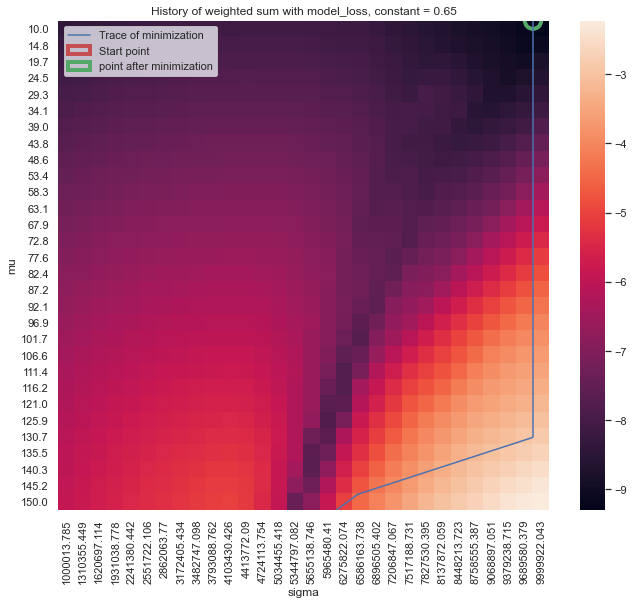

In [142]:
real_sigma_new = minimize_result_data_train_1.iloc[0]['data'][0]
real_mu_new = minimize_result_data_train_1.iloc[0]['data'][1]
constant = minimize_result_data_train_1.iloc[0]['constant']
sigma_history = []
mu_history = []
for i in history_train_1:
    sigma_history.append((i['sigma'] - sigma_real[0][0]) / sigma_real[1])
    mu_history.append((i['mu'] - mu_real[0][0]) / mu_real[1])
weighted_sum = -l2 + constant * loss_net
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(weighted_sum, annot=False)
name = "History of weighted sum with model_loss, constant = " + str(constant)
ax.set(xlabel='sigma', ylabel='mu', title=name)
ax = f.gca()
circle0 = plt.Circle(((fix_real_vector.get('Sigma').iloc[0] - sigma_real[0][0])/sigma_real[1],
                      (fix_real_vector.get('mu').iloc[0] - mu_real[0][0])/mu_real[1]),
                     0.5, color='r', fill=False, label="Start point", linewidth=4)
ax.add_patch(circle0)
circle1 = plt.Circle(((real_sigma_new - sigma_real[0][0])/sigma_real[1],(real_mu_new - mu_real[0][0])/mu_real[1]),
                     0.5, color='g', fill=False, label="point after minimization", linewidth=4)
ax.add_patch(circle1)
plt.plot(sigma_history, mu_history, label="Trace of minimization")
ax.legend()
f.savefig(name + '.png', bbox_inches='tight')

In [143]:
# history_train_2 = []
# def callbackF(xk, result):
#     history_train_2.append({'sigma': xk[0] * stds[0] + means[0],
#                    'mu':xk[1] * stds[1] + means[1]})
#     #print ('there is xk', [xk[0] * stds[0] + means[0], xk[1] * stds[1] + means[1]])
# minimize_result_data = []
# # constant = np.array([0.1, 0.2, 0.5, 0.7, 1, 2, 5])
# constant = np.array([0.65])
# for const in tqdm(constant):
#     def model_minimization_function(norm_variable_vector, constant=const):
#         real_sigma = norm_variable_vector[0] * stds[0] + means[0]
#         real_mu = norm_variable_vector[1] * stds[1] + means[1]
#         norm_sigma = norm_variable_vector[0]
#         norm_mu = norm_variable_vector[1]
#         return (-1 * l2_norm(norm_sigma, norm_mu) + constant * model_loss(real_sigma, real_mu))  
#     x0 = np.array([fix_normed_vector.get('Sigma').iloc[0],fix_normed_vector.get('mu').iloc[0]])
#     res =  minimize(model_minimization_function, x0, method='trust-constr', callback=callbackF,bounds=((norm_min_sigma,norm_max_sigma),
#                                                                    (norm_min_mu,norm_max_mu))
#                     ,options={'disp': False, 'xtol':1e-10
#                              })
#     minimize_result_data.append({'l2_norm': l2_norm(res.x[0], res.x[1]),
#                                  'log_loss': model_loss(res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1]),
#                                  'loss': np.exp(model_loss(res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1])),
#                                  'constant': const, 'data': (res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1]),
#                                  'message': res.message})
# minimize_result_data_train_2 = pd.DataFrame(minimize_result_data)
# minimize_result_data_train_2

In [144]:
# real_sigma_new = minimize_result_data_train_2.iloc[0]['data'][0]
# real_mu_new = minimize_result_data_train_2.iloc[0]['data'][1]
# constant = minimize_result_data_train_2.iloc[0]['constant']
# sigma_history = []
# mu_history = []
# for i in history_train_2:
#     sigma_history.append((i['sigma'] - sigma_real[0][0]) / sigma_real[1])
#     mu_history.append((i['mu'] - mu_real[0][0]) / mu_real[1])
# weighted_sum = -l2 + constant * loss_model
# f, ax = plt.subplots(figsize=(11, 9))
# sns.heatmap(weighted_sum, annot=False)
# name = "History of weighted sum with model_loss, constant = " + str(constant)
# ax.set(xlabel='sigma', ylabel='mu', title=name)
# ax = f.gca()
# circle0 = plt.Circle(((fix_real_vector.get('Sigma').iloc[0] - sigma_real[0][0])/sigma_real[1],
#                       (fix_real_vector.get('mu').iloc[0] - mu_real[0][0])/mu_real[1]),
#                      0.5, color='r', fill=False, label="Start point", linewidth=4)
# ax.add_patch(circle0)
# circle1 = plt.Circle(((real_sigma_new - sigma_real[0][0])/sigma_real[1],(real_mu_new - mu_real[0][0])/mu_real[1]),
#                      0.5, color='g', fill=False, label="point after minimization", linewidth=4)
# ax.add_patch(circle1)
# plt.plot(sigma_history, mu_history, label="Trace of minimization")
# ax.legend()
# f.savefig(name + '.png', bbox_inches='tight')

In [145]:
# history_train_3 = []
# def callbackF(xk, result):
#     history_train_3.append({'sigma': xk[0] * stds[0] + means[0],
#                    'mu':xk[1] * stds[1] + means[1]})
#     #print ('there is xk', [xk[0] * stds[0] + means[0], xk[1] * stds[1] + means[1]])
# minimize_result_data = []
# # constant = np.array([0.1, 0.2, 0.5, 0.7, 1, 2, 5])
# constant = np.array([0.2])
# for const in tqdm(constant):
#     def model_minimization_function(norm_variable_vector, constant=const):
#         real_sigma = norm_variable_vector[0] * stds[0] + means[0]
#         real_mu = norm_variable_vector[1] * stds[1] + means[1]
#         norm_sigma = norm_variable_vector[0]
#         norm_mu = norm_variable_vector[1]
#         return (-1 * l2_norm(norm_sigma, norm_mu) + constant * model_loss(real_sigma, real_mu))  
#     x0 = np.array([fix_normed_vector.get('Sigma').iloc[0],fix_normed_vector.get('mu').iloc[0]])
#     res =  minimize(model_minimization_function, x0, method='trust-constr', callback=callbackF,bounds=((norm_min_sigma,norm_max_sigma),
#                                                                    (norm_min_mu,norm_max_mu))
#                     ,options={'disp': False, 'xtol':1e-15
#                              })
#     minimize_result_data.append({'l2_norm': l2_norm(res.x[0], res.x[1]),
#                                  'log_loss': model_loss(res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1]),
#                                  'loss': np.exp(model_loss(res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1])),
#                                  'constant': const, 'data': (res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1]),
#                                  'message': res.message})
# minimize_result_data_train_3 = pd.DataFrame(minimize_result_data)
# minimize_result_data_train_3

In [146]:
# real_sigma_new = minimize_result_data_train_3.iloc[0]['data'][0]
# real_mu_new = minimize_result_data_train_3.iloc[0]['data'][1]
# constant = minimize_result_data_train_3.iloc[0]['constant']
# sigma_history = []
# mu_history = []
# for i in history_train_3:
#     sigma_history.append((i['sigma'] - sigma_real[0][0]) / sigma_real[1])
#     mu_history.append((i['mu'] - mu_real[0][0]) / mu_real[1])
# weighted_sum = -l2 + constant * loss_model
# f, ax = plt.subplots(figsize=(11, 9))
# sns.heatmap(weighted_sum, annot=False)
# name = "History of weighted sum with model_loss, constant = " + str(constant)
# ax.set(xlabel='sigma', ylabel='mu', title=name)
# ax = f.gca()
# circle0 = plt.Circle(((fix_real_vector.get('Sigma').iloc[0] - sigma_real[0][0])/sigma_real[1],
#                       (fix_real_vector.get('mu').iloc[0] - mu_real[0][0])/mu_real[1]),
#                      0.5, color='r', fill=False, label="Start point", linewidth=4)
# ax.add_patch(circle0)
# circle1 = plt.Circle(((real_sigma_new - sigma_real[0][0])/sigma_real[1],(real_mu_new - mu_real[0][0])/mu_real[1]),
#                      0.5, color='g', fill=False, label="point after minimization", linewidth=4)
# ax.add_patch(circle1)
# plt.plot(sigma_history, mu_history, label="Trace of minimization")
# ax.legend()
# f.savefig(name + '.png', bbox_inches='tight')

### При константе 0,2 для вектора 9030 смогли добиться значительного увеличения Л-2 нормы при относительно небольшом лоссе.

#### 1. Нарисуем спады, характерные этим константам и значением векторов

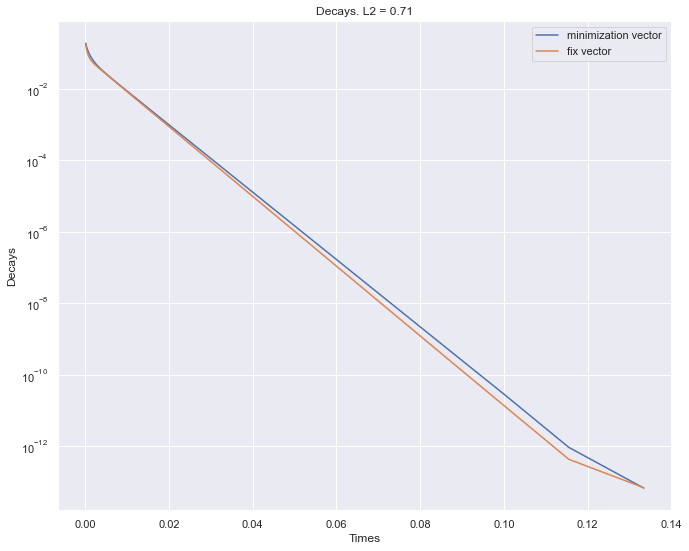

In [41]:
real_sigma_new = minimize_result_data_train_3.iloc[0]['data'][0]
real_mu_new = minimize_result_data_train_3.iloc[0]['data'][1]
f, ax = plt.subplots(figsize=(11, 9))
plt.plot(t,model_decay(sigma=real_sigma_new, mu=real_mu_new))
plt.plot(t,fix_real_vector.get('Decay').iloc[0])
plt.gca().set(xlabel='Times', ylabel='Decays')
name = 'Decays. L2 = ' + str(round(minimize_result_data_train_3.iloc[0]['l2_norm'],2))
plt.title(name)
ax.set_yscale('log')
plt.legend(labels=['minimization vector', 'fix vector'])

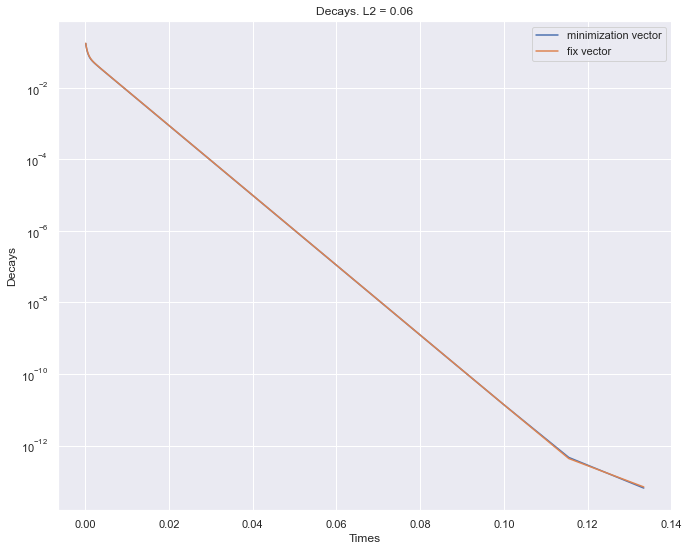

In [359]:
real_sigma_new = minimize_result_data_4.iloc[2]['data'][0]
real_mu_new = minimize_result_data_4.iloc[2]['data'][1]
f, ax = plt.subplots(figsize=(11, 9))
plt.plot(t,model_decay(sigma=real_sigma_new, mu=real_mu_new))
plt.plot(t,fix_real_vector.get('Decay').iloc[0])
plt.gca().set(xlabel='Times', ylabel='Decays')
name = 'Decays. L2 = ' + str(round(minimize_result_data_4.iloc[2]['l2_norm'],2))
plt.title(name)
ax.set_yscale('log')
plt.legend(labels=['minimization vector', 'fix vector'])

#### 2. Нарисовать зону, куда пришли. (Возможно уже устарело)

In [260]:
# ## Потом убрать 
# sigma_real = np.linspace(min_sigma, max_sigma, num=size, retstep=True)#sigma
# mu_real = np.linspace(min_mu, max_mu, num=size, retstep=True)#mu

1000013.7854274483

In [340]:
# history = []
# def callbackF(xk, result):
#     history.append({'sigma': xk[0] * stds[0] + means[0],
#                    'mu':xk[1] * stds[1] + means[1]})
#     #print ('there is xk', [xk[0] * stds[0] + means[0], xk[1] * stds[1] + means[1]])
# minimize_result_data = []
# constant = np.array([minimize_result_data_4.iloc[0]['constant']])
# for const in tqdm(constant):
#     def model_minimization_function(norm_variable_vector, constant=const):
#         real_sigma = norm_variable_vector[0] * stds[0] + means[0]
#         real_mu = norm_variable_vector[1] * stds[1] + means[1]
#         norm_sigma = norm_variable_vector[0]
#         norm_mu = norm_variable_vector[1]
#         return (-1 * l2_norm(norm_sigma, norm_mu) + constant * model_loss(real_sigma, real_mu))  
#     x0 = np.array([fix_normed_vector.get('Sigma').iloc[0],fix_normed_vector.get('mu').iloc[0]])
#     res =  minimize(model_minimization_function, x0, method='trust-constr', callback=callbackF,bounds=((norm_min_sigma,norm_max_sigma),
#                                                                    (norm_min_mu,norm_max_mu))
#                     ,options={'disp': False,
#                              })
#     minimize_result_data.append({'l2_norm': l2_norm(res.x[0], res.x[1]),
#                                  'log_loss': model_loss(res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1]),
#                                  'loss': np.exp(model_loss(res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1])),
#                                  'constant': const, 'data': (res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1]),
#                                  'message': res.message})
# minimize_result_data_5 = pd.DataFrame(minimize_result_data)
# minimize_result_data_5

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [18:20<00:00, 1100.48s/it]


,l2_norm,log_loss,loss,constant,data,message
0,0.898061,-11.003899,0.000017,0.1,"(2722502.561642618, 51.34362107846994)",`xtol` termination condition is satisfied.


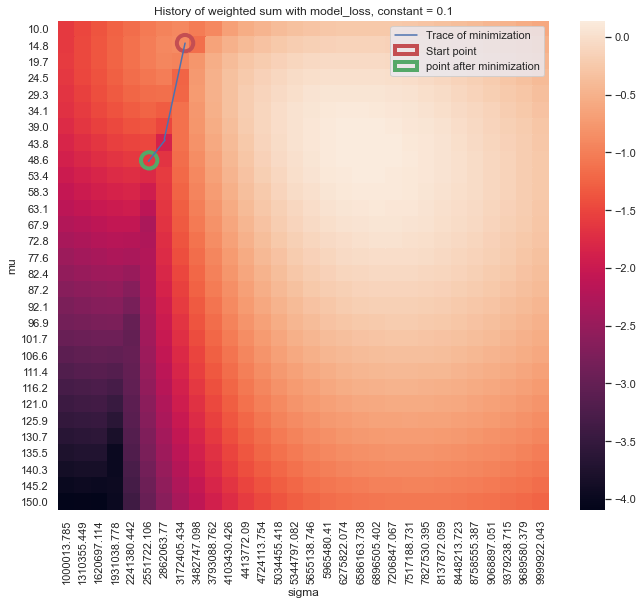

In [341]:
# real_sigma_new = minimize_result_data_5.iloc[0]['data'][0]
# real_mu_new = minimize_result_data_5.iloc[0]['data'][1]
# constant = minimize_result_data_5.iloc[0]['constant']
# sigma_history = []
# mu_history = []
# for i in history:
#     sigma_history.append((i['sigma'] - sigma_real[0][0]) / sigma_real[1])
#     mu_history.append((i['mu'] - mu_real[0][0]) / mu_real[1])
# weighted_sum = -l2 + constant * loss_model
# f, ax = plt.subplots(figsize=(11, 9))
# sns.heatmap(weighted_sum, annot=False)
# name = "History of weighted sum with model_loss, constant = " + str(constant)
# ax.set(xlabel='sigma', ylabel='mu', title=name)
# ax = f.gca()
# circle0 = plt.Circle(((fix_real_vector.get('Sigma').iloc[0] - sigma_real[0][0])/sigma_real[1],
#                       (fix_real_vector.get('mu').iloc[0] - mu_real[0][0])/mu_real[1]),
#                      0.5, color='r', fill=False, label="Start point", linewidth=4)
# ax.add_patch(circle0)
# circle1 = plt.Circle(((real_sigma_new - sigma_real[0][0])/sigma_real[1],(real_mu_new - mu_real[0][0])/mu_real[1]),
#                      0.5, color='g', fill=False, label="point after minimization", linewidth=4)
# ax.add_patch(circle1)
# plt.plot(sigma_history, mu_history, label="Trace of minimization")
# ax.legend()
# f.savefig(name + '.png', bbox_inches='tight')

In [342]:
# history = []
# def callbackF(xk, result):
#     history.append({'sigma': xk[0] * stds[0] + means[0],
#                    'mu':xk[1] * stds[1] + means[1]})
#     #print ('there is xk', [xk[0] * stds[0] + means[0], xk[1] * stds[1] + means[1]])
# minimize_result_data = []
# constant = np.array([minimize_result_data_4.iloc[2]['constant']])
# for const in tqdm(constant):
#     def model_minimization_function(norm_variable_vector, constant=const):
#         real_sigma = norm_variable_vector[0] * stds[0] + means[0]
#         real_mu = norm_variable_vector[1] * stds[1] + means[1]
#         norm_sigma = norm_variable_vector[0]
#         norm_mu = norm_variable_vector[1]
#         return (-1 * l2_norm(norm_sigma, norm_mu) + constant * model_loss(real_sigma, real_mu))  
#     x0 = np.array([fix_normed_vector.get('Sigma').iloc[0],fix_normed_vector.get('mu').iloc[0]])
#     res =  minimize(model_minimization_function, x0, method='trust-constr', callback=callbackF,bounds=((norm_min_sigma,norm_max_sigma),
#                                                                    (norm_min_mu,norm_max_mu))
#                     ,options={'disp': False,
#                              })
#     minimize_result_data.append({'l2_norm': l2_norm(res.x[0], res.x[1]),
#                                  'log_loss': model_loss(res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1]),
#                                  'loss': np.exp(model_loss(res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1])),
#                                  'constant': const, 'data': (res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1]),
#                                  'message': res.message})
# minimize_result_data_6 = pd.DataFrame(minimize_result_data)
# minimize_result_data_6

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [06:49<00:00, 409.82s/it]


,l2_norm,log_loss,loss,constant,data,message
0,0.057997,-12.488134,0.000004,0.5,"(3467113.5268488093, 14.519950869112606)",`xtol` termination condition is satisfied.


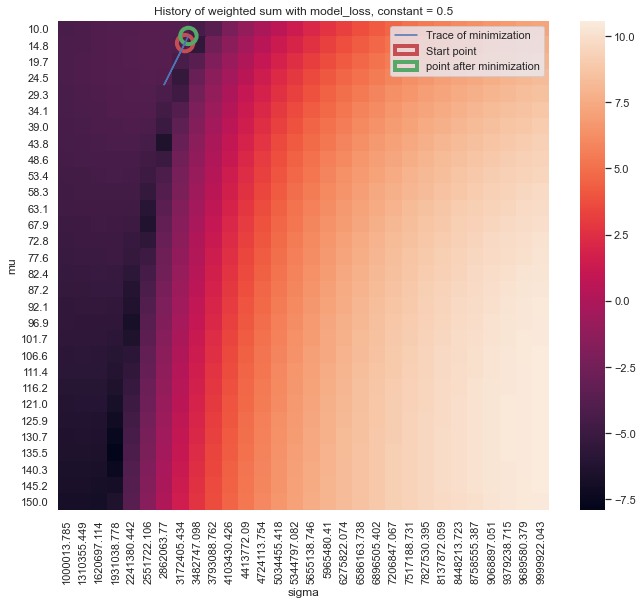

In [343]:
# real_sigma_new = minimize_result_data_6.iloc[0]['data'][0]
# real_mu_new = minimize_result_data_6.iloc[0]['data'][1]
# constant = minimize_result_data_6.iloc[0]['constant']
# sigma_history = []
# mu_history = []
# for i in history:
#     sigma_history.append((i['sigma'] - sigma_real[0][0]) / sigma_real[1])
#     mu_history.append((i['mu'] - mu_real[0][0]) / mu_real[1])
# weighted_sum = -l2 + constant * loss_model
# f, ax = plt.subplots(figsize=(11, 9))
# sns.heatmap(weighted_sum, annot=False)
# name = "History of weighted sum with model_loss, constant = " + str(constant)
# ax.set(xlabel='sigma', ylabel='mu', title=name)
# ax = f.gca()
# circle0 = plt.Circle(((fix_real_vector.get('Sigma').iloc[0] - sigma_real[0][0])/sigma_real[1],
#                       (fix_real_vector.get('mu').iloc[0] - mu_real[0][0])/mu_real[1]),
#                      0.5, color='r', fill=False, label="Start point", linewidth=4)
# ax.add_patch(circle0)
# circle1 = plt.Circle(((real_sigma_new - sigma_real[0][0])/sigma_real[1],(real_mu_new - mu_real[0][0])/mu_real[1]),
#                      0.5, color='g', fill=False, label="point after minimization", linewidth=4)
# ax.add_patch(circle1)
# plt.plot(sigma_history, mu_history, label="Trace of minimization")
# ax.legend()
# f.savefig(name + '.png', bbox_inches='tight')

### Пробуем нейросетевой подход

In [350]:
def callbackF(xk, result):
    print ('there is xk', [xk[0] * stds[0] + means[0], xk[1] * stds[1] + means[1]])
minimize_result_data = []
constant = np.array([0.2])
#constant = np.linspace(1e-03,0.5,10)
for const in tqdm(constant):
    def model_minimization_function(norm_variable_vector, constant=const):
        real_sigma = norm_variable_vector[0] * stds[0] + means[0]
        real_mu = norm_variable_vector[1] * stds[1] + means[1]
        norm_sigma = norm_variable_vector[0]
        norm_mu = norm_variable_vector[1]
        return (-1 * l2_norm(norm_sigma, norm_mu) + constant * net_loss(norm_sigma, norm_mu))  
    x0 = np.array([fix_normed_vector.get('Sigma').iloc[0],fix_normed_vector.get('mu').iloc[0]])
    res =  minimize(model_minimization_function, x0, method='trust-constr', callback=None,bounds=((norm_min_sigma,norm_max_sigma),
                                                                   (norm_min_mu,norm_max_mu))
                    ,options={'disp': False,
                             })
    minimize_result_data.append({'l2_norm': l2_norm(res.x[0], res.x[1]),
                                 'log_loss': model_loss(res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1]),
                                 'loss': np.exp(model_loss(res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1])),
                                 'constant': const, 'data': (res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1]),
                                 'message': res.message})
minimize_result_data_net = pd.DataFrame(minimize_result_data)
minimize_result_data_net

 10%|████████▎                                                                          | 1/10 [00:03<00:33,  3.74s/it]C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:40<00:00,  4.03s/it]


,l2_norm,log_loss,loss,constant,data,message
0,3.427600,-6.733456,0.001190,0.001000,"(1001443.2217417704, 149.99307401129636)",`gtol` termination condition is satisfied.
1,3.427731,-6.748185,0.001173,0.056444,"(1000530.7323607709, 149.99457518810618)",`gtol` termination condition is satisfied.
2,3.358586,-7.854309,0.000388,0.111889,"(1726724.0916710328, 149.83037321861977)",`xtol` termination condition is satisfied.
3,3.427795,-6.760200,0.001159,0.167333,"(1000478.8056935426, 149.9970356549817)",`gtol` termination condition is satisfied.
4,3.362732,-7.816392,0.000403,0.222778,"(1724684.1040182896, 149.9949119333353)",`xtol` termination condition is satisfied.
5,3.355896,-7.885832,0.000376,0.278222,"(1728047.0550431418, 149.72366972645239)",`xtol` termination condition is satisfied.
6,1.104317,-6.654620,0.001288,0.333667,"(1444302.2497706981, 49.13425216435971)",`xtol` termination condition is satisfied.
7,3.393834,-6.744502,0.001177,0.389111,"(1265919.5960479043, 149.68022288974225)",`xtol` termination condition is satisfied.
8,3.427762,-6.696027,0.001236,0.444556,"(1000815.8133141417, 149.99712045621382)",`gtol` termination condition is satisfied.
9,3.359047,-7.608714,0.000496,0.500000,"(1726497.2667401675, 149.84866990427673)",`xtol` termination condition is satisfied.


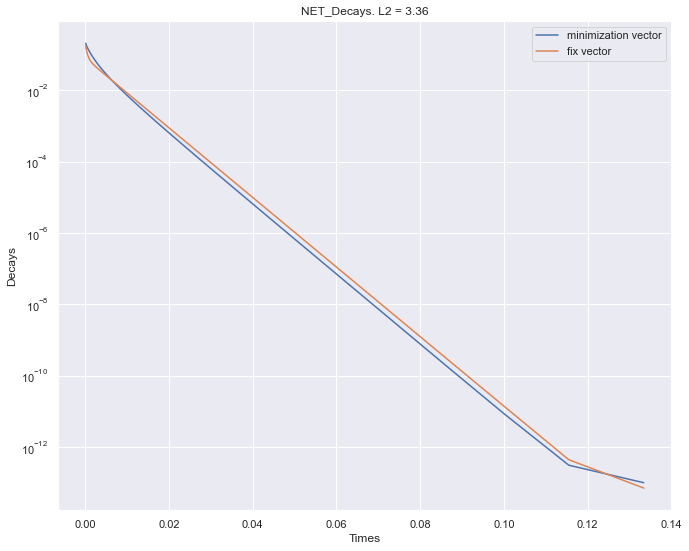

In [357]:
real_sigma_new = minimize_result_data_net.iloc[5]['data'][0]
real_mu_new = minimize_result_data_net.iloc[5]['data'][1]
f, ax = plt.subplots(figsize=(11, 9))
plt.plot(t,model_decay(sigma=real_sigma_new, mu=real_mu_new))
plt.plot(t,fix_real_vector.get('Decay').iloc[0])
plt.gca().set(xlabel='Times', ylabel='Decays')
name = 'NET_Decays. L2 = ' + str(round(minimize_result_data_net.iloc[5]['l2_norm'],2))
plt.title(name)
ax.set_yscale('log')
plt.legend(labels=['minimization vector', 'fix vector'])

In [157]:
history_net = []
def callbackF(xk, result):
    history_net.append({'sigma': xk[0] * stds[0] + means[0],
                   'mu':xk[1] * stds[1] + means[1]})
    #print ('there is xk', [xk[0] * stds[0] + means[0], xk[1] * stds[1] + means[1]])
minimize_result_data = []
#constant = np.array([minimize_result_data_net.iloc[5]['constant']])
constant =  np.array([1e-7])
for const in tqdm(constant):
    def model_minimization_function(norm_variable_vector, constant=const):
        real_sigma = norm_variable_vector[0] * stds[0] + means[0]
        real_mu = norm_variable_vector[1] * stds[1] + means[1]
        norm_sigma = norm_variable_vector[0]
        norm_mu = norm_variable_vector[1]
        return (-1 * l2_norm(norm_sigma, norm_mu) + constant * net_loss(norm_sigma, norm_mu))  
    x0 = np.array([fix_normed_vector.get('Sigma').iloc[0],fix_normed_vector.get('mu').iloc[0]])
    res =  minimize(model_minimization_function, x0, method='trust-constr', callback=callbackF,bounds=((norm_min_sigma,norm_max_sigma),
                                                                   (norm_min_mu,norm_max_mu))
                    ,options={'disp': False, 'xtol':1e-15, 'initial_constr_penalty': 0.1,
                              'maxiter':1e5, 'initial_tr_radius': 0.5
                             })
    minimize_result_data.append({'l2_norm': l2_norm(res.x[0], res.x[1]),
                                 'log_loss': model_loss(res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1]),
                                 'loss': np.exp(model_loss(res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1])),
                                 'constant': const, 'data': (res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1]),
                                 'message': res.message})
minimize_result_data_7 = pd.DataFrame(minimize_result_data)
minimize_result_data_7

100%|█████████████████████████████████████████| 1/1 [00:03<00:00,  3.73s/it]


,l2_norm,log_loss,loss,constant,data,message
0,4.202388,4.355837,77.932047,1.000000e-07,"(1001058.0365980938, 10.009849170574668)",`gtol` termination condition is satisfied.


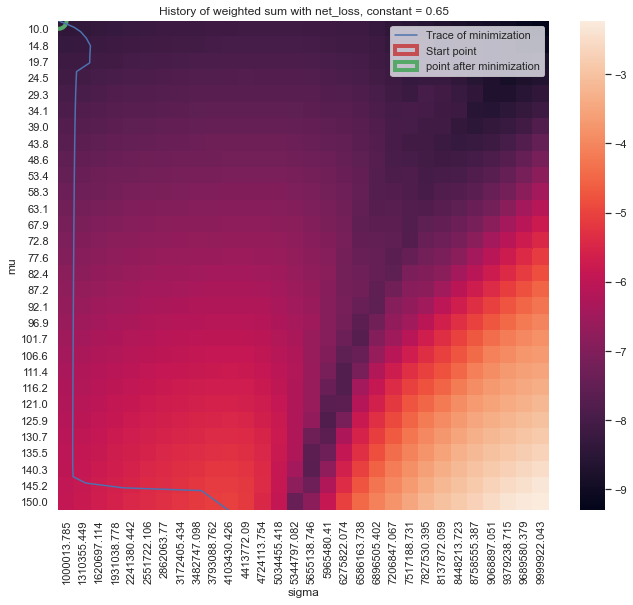

In [158]:
real_sigma_new = minimize_result_data_7.iloc[0]['data'][0]
real_mu_new = minimize_result_data_7.iloc[0]['data'][1]
#constant = minimize_result_data_7.iloc[0]['constant']
constant = 0.65
sigma_history = []
mu_history = []
for i in history_net:
    sigma_history.append((i['sigma'] - sigma_real[0][0]) / sigma_real[1])
    mu_history.append((i['mu'] - mu_real[0][0]) / mu_real[1])
weighted_sum = -l2 + constant * loss_net
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(weighted_sum, annot=False)
name = "History of weighted sum with net_loss, constant = " + str(constant)
ax.set(xlabel='sigma', ylabel='mu', title=name)
ax = f.gca()
circle0 = plt.Circle(((fix_real_vector.get('Sigma').iloc[0] - sigma_real[0][0])/sigma_real[1],
                      (fix_real_vector.get('mu').iloc[0] - mu_real[0][0])/mu_real[1]),
                     0.5, color='r', fill=False, label="Start point", linewidth=4)
ax.add_patch(circle0)
circle1 = plt.Circle(((real_sigma_new - sigma_real[0][0])/sigma_real[1],(real_mu_new - mu_real[0][0])/mu_real[1]),
                     0.5, color='g', fill=False, label="point after minimization", linewidth=4)
ax.add_patch(circle1)
plt.plot(sigma_history, mu_history, label="Trace of minimization")
ax.legend()
f.savefig(name + '.png', bbox_inches='tight')

### Пробуем БФГС для сетки

In [147]:
history_net_bfgs = []
def callbackF(xk):
    print({'sigma': xk[0] * stds[0] + means[0],
                   'mu':xk[1] * stds[1] + means[1]})
    history_net_bfgs.append({'sigma': xk[0] * stds[0] + means[0],
                   'mu':xk[1] * stds[1] + means[1]})
    #print ('there is xk', [xk[0] * stds[0] + means[0], xk[1] * stds[1] + means[1]])
minimize_result_data = []
#constant = np.array([minimize_result_data_net.iloc[5]['constant']])
constant =  np.array([0.65])
for const in tqdm(constant):
    def net_minimization_function(norm_variable_vector, constant=const):
        real_sigma = norm_variable_vector[0] * stds[0] + means[0]
        real_mu = norm_variable_vector[1] * stds[1] + means[1]
        norm_sigma = norm_variable_vector[0]
        norm_mu = norm_variable_vector[1]
        return (-1 * l2_norm(norm_sigma, norm_mu) + constant * net_loss(norm_sigma, norm_mu))  
    x0 = np.array([fix_normed_vector.get('Sigma').iloc[0],fix_normed_vector.get('mu').iloc[0]])
    res =  minimize(model_minimization_function, x0, method='L-BFGS-B', callback=callbackF,bounds=((norm_min_sigma,norm_max_sigma),
                                                                   (norm_min_mu,norm_max_mu))
                    ,options={'disp': False, 'gtol': 1e-20, 
                             })
    minimize_result_data.append({'l2_norm': l2_norm(res.x[0], res.x[1]),
                                 'log_loss': model_loss(res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1]),
                                 'loss': np.exp(model_loss(res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1])),
                                 'constant': const, 'data': (res.x[0] * stds[0] + means[0], res.x[1] * stds[1] + means[1]),
                                 'message': res.message})
minimize_result_data_bfgs = pd.DataFrame(minimize_result_data)
minimize_result_data_bfgs

  0%|                                                 | 0/1 [00:00<?, ?it/s]

{'sigma': 5302180.458521496, 'mu': 149.9982142824673}


100%|████████████████████████████████████████| 1/1 [03:00<00:00, 180.45s/it]


,l2_norm,log_loss,loss,constant,data,message
0,0.395925,38.714413,6.508124e+16,0.65,"(5302180.458521496, 149.9982142824673)",b'ABNORMAL_TERMINATION_IN_LNSRCH'


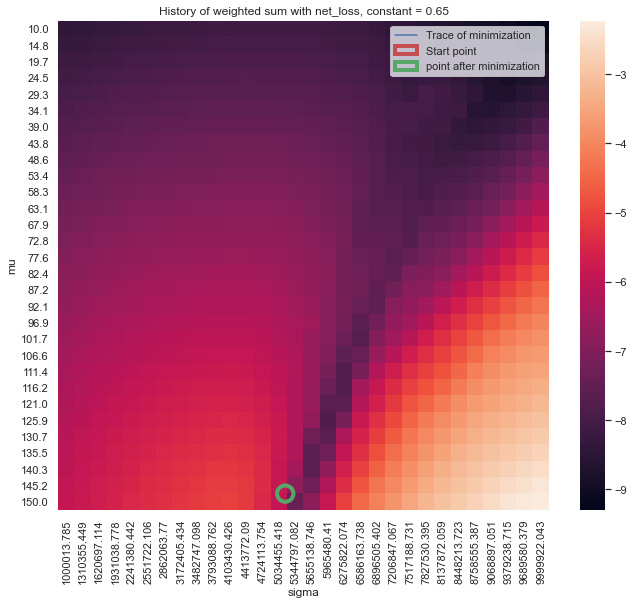

In [150]:
real_sigma_new = minimize_result_data_bfgs.iloc[0]['data'][0]
real_mu_new = minimize_result_data_bfgs.iloc[0]['data'][1]
#constant = minimize_result_data_7.iloc[0]['constant']
constant = 0.65
sigma_history = []
mu_history = []
for i in history_net_bfgs:
    sigma_history.append((i['sigma'] - sigma_real[0][0]) / sigma_real[1])
    mu_history.append((i['mu'] - mu_real[0][0]) / mu_real[1])
weighted_sum = -l2 + constant * loss_net
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(weighted_sum, annot=False)
name = "History of weighted sum with net_loss, constant = " + str(constant)
ax.set(xlabel='sigma', ylabel='mu', title=name)
ax = f.gca()
circle0 = plt.Circle(((fix_real_vector.get('Sigma').iloc[0] - sigma_real[0][0])/sigma_real[1],
                      (fix_real_vector.get('mu').iloc[0] - mu_real[0][0])/mu_real[1]),
                     0.5, color='r', fill=False, label="Start point", linewidth=4)
ax.add_patch(circle0)
circle1 = plt.Circle(((real_sigma_new - sigma_real[0][0])/sigma_real[1],(real_mu_new - mu_real[0][0])/mu_real[1]),
                     0.5, color='g', fill=False, label="point after minimization", linewidth=4)
ax.add_patch(circle1)
plt.plot(sigma_history, mu_history, label="Trace of minimization")
ax.legend()
f.savefig(name + '.png', bbox_inches='tight')

[]